# **Beijing Air Quality Forecasting**

#### **Project Overview**

 This notebook records application of machine learning techniques, specifically Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) models, to predict air pollution levels.

#### **Problem:**

Air pollution poses a significant global challenge, with PM2.5 among the most hazardous pollutants due to its capacity to infiltrate deep into the lungs and reach the bloodstream. Predicting PM2.5 levels with precision enables governments and communities to take proactive steps to enhance air quality and safeguard public health.

 - The goal is to a model that accurately forecasts PM2.5 concentrations (a key air quality measure) using historical air quality and weather data.


### **Overall approach to the pipeline**

- Time-Series Strategy: I use sliding-window sequences (24-hour lookback) to feed temporal context into models, preserving chronological order throughout training.

- Justification for RNNs/LSTMs: RNN variants (LSTM, GRU) excel at capturing temporal dependencies and long-term patterns, which are critical for forecasting PM2.5 influenced by both recent and seasonal trends.

**Exploratory Plan**:

- Examine distribution and missingness of PM2.5 and meteorological features.

- Visualize cyclical patterns (daily and weekly) to inform feature engineering.

- Preprocessing Pipeline: As detailed above, combining advanced interpolation, cyclical encoding, rush-hour/weekend flags, robust scaling, and 24-hour sequencing.

**Model Experimental Plan**:

- Baseline: Simple single-layer LSTM to establish a performance floor.

- Cell Variants: Replace LSTM with GRU to test training speed vs. accuracy trade-offs.

- Bidirectionality: Explore bidirectional LSTM to capture both past and future context.

- Hybrid Architectures: Add a CNN layer to extract local temporal features before LSTM.

- Depth & Regularization: Stack multiple LSTM layers with dropout to increase representational capacity while controlling overfitting.

- Hyperparameter Tuning: Adjust number of units, dropout rates, learning rates, and batch sizes using RMSE as the guiding metric.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025
!mkdir '/content/data'
!unzip -qo 'assignment-1-time-series-forecasting-may-2025.zip' -d '/content/data'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
assignment-1-time-series-forecasting-may-2025.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘/content/data’: File exists


#### Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (LSTM, GRU, Dense, Dropout, BatchNormalization,
                                   Input, Bidirectional, Conv1D, MaxPooling1D,
                                   Flatten, Concatenate, GlobalMaxPooling1D)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

## Data Exploration, Preprocessing and Feature Engineering

**Data Visualizations are in a separate notebook**

In [ ]:
# file path
train_path = '/content/data/train.csv'
test_path = '/content/data/test.csv'

# load data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# convert datetime
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df.index = pd.to_datetime(test_df.index)

# sort by datetime to ensure chronological order
train_df = train_df.sort_values('datetime').reset_index(drop=True)
test_df = test_df.sort_index()

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Missing PM2.5 values in training: {train_df['pm2.5'].isna().sum()}")

Training data shape: (30676, 12)
Test data shape: (13148, 11)
Missing PM2.5 values in training: 1921


### **Handling missing values and Creating temporal features**

**Datetime Features**:
- Adding temporal features like hour, day_of_week, month, and season helps the model capture cyclical patterns.

- The cyclical encoding (sine and cosine transformations) is particularly effective for handling cyclical time features.


**Advanced Interpolation:**
- Weighted interpolation using weather similarity and temporal proximity ensures realistic PM2.5 estimates by leveraging contextual patterns (e.g., similar weather conditions at the same hour/day).

**Seasonal Imputation:**
- Grouping by month/hour to fill remaining gaps aligns with cyclical pollution trends (e.g., higher PM2.5 in winter due to heating).

In [ ]:
# CREATING TEMPORAL FEATURES AND HANDLING MISSING VALUES

# Process training data
df = train_df.copy()
datetime_col = 'datetime'

# add temporal features to train_df copy
if datetime_col in df.columns:
  dt = pd.to_datetime(df[datetime_col])
else:
  dt = df.index

# basic temporal features for training data
df['hour'] = dt.dt.hour
df['day_of_week'] = dt.dt.dayofweek
df['month'] = dt.dt.month
df['season'] = ((dt.dt.month % 12 + 3) // 3) - 1

# cyclical encoding for training data
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# rush hour indicators for training data
df['is_rush_hour'] = ((df['hour'].between(7, 9)) |
                     (df['hour'].between(17, 19))).astype(int)
df['is_weekend'] = (df['day_of_week'].isin([5, 6])).astype(int)


# handling missing values on the same DataFrame (train_df copy)
missing_mask = df['pm2.5'].isna()

print(f"Handling {missing_mask.sum()} missing PM2.5 values in training data...")

method = 'advanced_interpolation'

if method == 'advanced_interpolation':
  # use time aware interpolation with meteorological context
  # make sure datetime is the index before interpolating
  df = df.set_index('datetime')

  # group by similar weather conditions for better interpolation
  weather_features = ['TEMP', 'DEWP', 'PRES', 'Iws']

  # try interpolation within similar weather conditions
  for idx in df[df['pm2.5'].isna()].index:
    # find similar weather conditions within 3 days
    window_start = idx - pd.Timedelta(days=3)
    window_end = idx + pd.Timedelta(days=3)
    window_data = df.loc[window_start:window_end]

    if not window_data.empty and not window_data['pm2.5'].isna().all():
      # calculate weather similarity
      current_weather = df.loc[idx, weather_features]
      similar_conditions = window_data.dropna(subset=['pm2.5'])

      if len(similar_conditions) > 0:
        # weight by weather similarity and temporal distance
        weather_distances = np.sqrt(((similar_conditions[weather_features] -
                                   current_weather) ** 2).sum(axis=1))
        time_distances = np.abs((similar_conditions.index - idx).total_seconds() / 3600)

        # combined similarity score
        weights = 1 / (1 + weather_distances + time_distances / 24)
        weighted_pm25 = np.average(similar_conditions['pm2.5'], weights=weights)
        df.loc[idx, 'pm2.5'] = weighted_pm25

  # fill remaining missing values with seasonal patterns
  # ensure 'month' and 'hour' columns exist before grouping
  df['pm2.5'] = df.groupby(['month', 'hour'])['pm2.5'].transform(
      lambda x: x.fillna(x.median())
  )

  # final interpolation for any remaining missing values
  df['pm2.5'] = df['pm2.5'].interpolate(method='time', limit_direction='both')

  df = df.reset_index()

# display head of the processed training dataframe to verify
print("Processed training data head:")
display(df.head())

# Now, process the test data
test_df_processed = test_df.copy()
datetime_col = 'datetime'

# add temporal features to test_df copy
# The test_df index is already datetime, so we use test_df_processed.index
dt_test = test_df_processed.index

# basic temporal features for test data
test_df_processed['hour'] = dt_test.hour
test_df_processed['day_of_week'] = dt_test.dayofweek
test_df_processed['month'] = dt_test.month
test_df_processed['season'] = ((dt_test.month % 12 + 3) // 3) - 1

# cyclical encoding for test data
test_df_processed['hour_sin'] = np.sin(2 * np.pi * test_df_processed['hour'] / 24)
test_df_processed['hour_cos'] = np.cos(2 * np.pi * test_df_processed['hour'] / 24)
test_df_processed['day_sin'] = np.sin(2 * np.pi * test_df_processed['day_of_week'] / 7)
test_df_processed['day_cos'] = np.cos(2 * np.pi * test_df_processed['day_of_week'] / 7)
test_df_processed['month_sin'] = np.sin(2 * np.pi * test_df_processed['month'] / 12)
test_df_processed['month_cos'] = np.cos(2 * np.pi * test_df_processed['month'] / 12)

# rush hour indicators for test data
test_df_processed['is_rush_hour'] = ((test_df_processed['hour'].between(7, 9)) |
                     (test_df_processed['hour'].between(17, 19))).astype(int)
test_df_processed['is_weekend'] = (test_df_processed['day_of_week'].isin([5, 6])).astype(int)


print("\nMissing values in test data before handling:")
print(test_df_processed.isnull().sum())

# simple forward fill for any potential missing other features
test_df_processed = test_df_processed.fillna(method='ffill')
test_df_processed = test_df_processed.fillna(method='bfill') # Backfill for any remaining nans at the start

print("\nMissing values in test data after handling:")
print(test_df_processed.isnull().sum())


# display head of the processed test dataframe to verify
print("\nProcessed test data head:")
display(test_df_processed.head())

# Update the train_df variable to the processed version
train_df = df.copy()

# Update the test_df variable to the processed version
test_df = test_df_processed.copy()

Handling 1921 missing PM2.5 values in training data...
Processed training data head:


,datetime,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,...,month,season,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,is_rush_hour,is_weekend
0,2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,...,1,0,0.000000,1.000000,-0.433884,-0.900969,0.5,0.866025,0,0
1,2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,...,1,0,0.258819,0.965926,-0.433884,-0.900969,0.5,0.866025,0,0
2,2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,...,1,0,0.500000,0.866025,-0.433884,-0.900969,0.5,0.866025,0,0
3,2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,...,1,0,0.707107,0.707107,-0.433884,-0.900969,0.5,0.866025,0,0
4,2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,...,1,0,0.866025,0.500000,-0.433884,-0.900969,0.5,0.866025,0,0



Missing values in test data before handling:
No              0
DEWP            0
TEMP            0
PRES            0
Iws             0
Is              0
Ir              0
datetime        0
cbwd_NW         0
cbwd_SE         0
cbwd_cv         0
hour            0
day_of_week     0
month           0
season          0
hour_sin        0
hour_cos        0
day_sin         0
day_cos         0
month_sin       0
month_cos       0
is_rush_hour    0
is_weekend      0
dtype: int64

Missing values in test data after handling:
No              0
DEWP            0
TEMP            0
PRES            0
Iws             0
Is              0
Ir              0
datetime        0
cbwd_NW         0
cbwd_SE         0
cbwd_cv         0
hour            0
day_of_week     0
month           0
season          0
hour_sin        0
hour_cos        0
day_sin         0
day_cos         0
month_sin       0
month_cos       0
is_rush_hour    0
is_weekend      0
dtype: int64

Processed test data head:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,...,month,season,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,is_rush_hour,is_weekend
1970-01-01 00:00:00.000000000,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,2013-07-02 04:00:00,1.448138,-0.732019,...,1,0,0.0,1.0,0.433884,-0.900969,0.5,0.866025,0,0
1970-01-01 00:00:00.000000001,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,2013-07-02 05:00:00,1.448138,-0.732019,...,1,0,0.0,1.0,0.433884,-0.900969,0.5,0.866025,0,0
1970-01-01 00:00:00.000000002,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,2013-07-02 06:00:00,1.448138,-0.732019,...,1,0,0.0,1.0,0.433884,-0.900969,0.5,0.866025,0,0
1970-01-01 00:00:00.000000003,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,2013-07-02 07:00:00,1.448138,-0.732019,...,1,0,0.0,1.0,0.433884,-0.900969,0.5,0.866025,0,0
1970-01-01 00:00:00.000000004,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,2013-07-02 08:00:00,1.448138,-0.732019,...,1,0,0.0,1.0,0.433884,-0.900969,0.5,0.866025,0,0


### **Scaling**

**RobustScaler** reduces outlier impact, critical for meteorological features like wind speed (Iws) and pressure (PRES).

In [ ]:
# SCALING

# reset index and rename the first column to "datetime"
test_df = test_df.reset_index(drop=True)
if test_df.columns[0] != 'datetime':
    test_df.rename(columns={test_df.columns[0]: 'datetime'}, inplace=True)

# Identify feature columns (exclude the non-feature columns: 'No', 'datetime', and 'pm2.5')
feature_cols = [col for col in train_df.columns if col not in ['No', 'datetime', 'pm2.5']]
print("Scaling feature columns:", feature_cols)

feature_scaler = RobustScaler()
target_scaler = RobustScaler()

# Fit scalers on the training data and transform both sets
train_df[feature_cols] = feature_scaler.fit_transform(train_df[feature_cols])
train_df[['pm2.5']] = target_scaler.fit_transform(train_df[['pm2.5']])
test_df[feature_cols] = feature_scaler.transform(test_df[feature_cols])

Scaling feature columns: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'hour', 'day_of_week', 'month', 'season', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'is_rush_hour', 'is_weekend']


### **Sequencing**

**24-Hour Sliding Window** aligns with the daily cycle of pollution, enabling models to learn short-term dependencies (e.g., overnight drops in PM2.5).



In [ ]:
# SEQUENCING
sequence_length = 24

def create_sequences_from_df(df, target_col='pm2.5'):
    # exclude non-feature columns from sequence creation
    feat_columns = [col for col in df.columns if col not in ['No', 'datetime', target_col]]
    features = df[feat_columns].values
    targets = df[target_col].values if target_col in df.columns else None
    X, y = [], []
    for i in range(sequence_length, len(df)):
        X.append(features[i-sequence_length:i])
        if targets is not None:
            y.append(targets[i])
    X = np.array(X)
    y = np.array(y) if targets is not None else None
    print(f"Created sequences - X shape: {X.shape}, y shape: {y.shape if y is not None else 'None'}")
    return X, y
X_train, y_train = create_sequences_from_df(train_df, target_col='pm2.5')
X_test, _ = create_sequences_from_df(test_df, target_col='pm2.5')

print(f"Final data shapes - X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}")


Created sequences - X shape: (30652, 24, 21), y shape: (30652,)
Created sequences - X shape: (13124, 24, 21), y shape: None
Final data shapes - X_train: (30652, 24, 21), y_train: (30652,), X_test: (13124, 24, 21)


## **Model Architectures and Training**

### **Model Performance Analysis**

| Model      | Architecture                   | Validation RSME | Insights                                                                |
|------------|--------------------------------|-----------------|-------------------------------------------------------------------------|
| Model 1    | Single LSTM (32 units)         | 15746.38        | Underfitting: Too shallow to capture complex temporal dependencies      |
| Model 2    | Stacked LSTM (64-32 + Dropout) | 8896.67         | Improved depth and dropout reduced overfitting, but limited capacity    |
| Model 3    | Bidirectional LSTM             | 8468.98         | Bidirectional layers captured past/future context but added noise       |
| Model 4    | GRU + BatchNorm + Deep Layers  | **7514.97**     | Best performance: GRUs trained faster; BatchNorm stabilized gradients   |
| Model 5    | Hybrid CNN-LSTM                | 14956.67        | Overfitting: CNN layers likely extracted irrelevant local features      |
| Model 8    | Lightweight CNN-GRU            | 19087.91        | Simplistic architecture + high learning rate caused instability         |
| Model 7    | MultiScale GRU Ensemble        | 17338.92        | Branch merging introduced noise; insufficient regularization            |
| Model 6    | Stacked LSTM + Dropout         | 10,110.41       | Moderate depth helped but lacked GRU's efficiency                       |
| Model_TCN  | Temporal Convolutional Network | 9693.68         | Dilated convolutions captured long-range dependencies but needed tuning |
| Model_GRU  | Bidirectional GRU              | 10026.58        | Bidirectionality added minimal value; simpler GRU(model 4) outperformed |

### **Model 1: LSTM (Baseline)**

In [ ]:
model1 = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model1.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,945 (27.13 KB)

 Trainable params: 6,945 (27.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train with early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history1 = model1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - lambda: 0.9845 - loss: 0.5578
Epoch 2/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - lambda: 1.0494 - loss: 0.3308
Epoch 3/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - lambda: 1.0654 - loss: 0.2960
Epoch 4/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - lambda: 1.0777 - loss: 0.2679
Epoch 5/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - lambda: 1.0871 - loss: 0.2455
Epoch 6/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - lambda: 1.0933 - loss: 0.2296
Epoch 7/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - lambda: 1.1003 - loss: 0.2146
Epoch 8/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - lambda: 1.1064 - loss: 0.2024
Epoch 9/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - lambda: 1.1117 - loss: 0.1900
Epoch 10/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - lambda: 1.1161 - loss: 0.1817
Epoch 11/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - lambda: 1.1196 - loss: 0.1749
Epoch 12/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - lamb

958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Model 1 Training RMSE: 0.2992563392171485


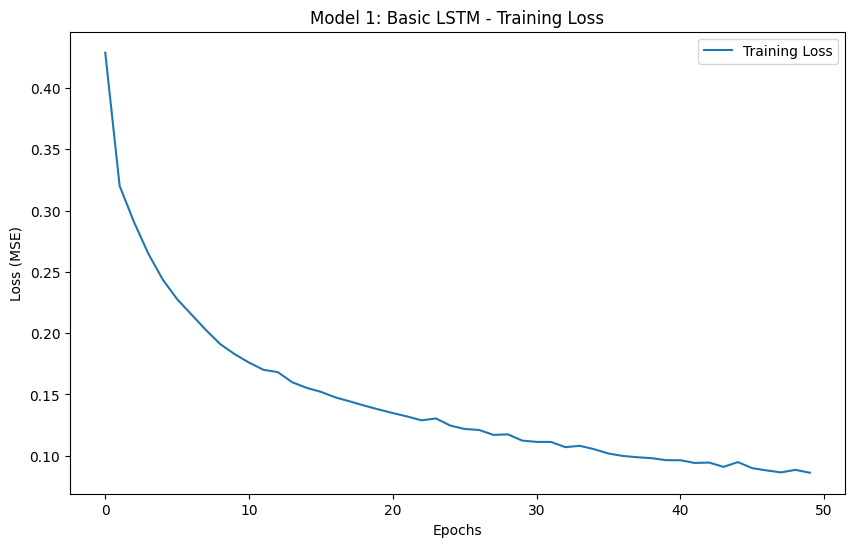

In [ ]:
# Evaluate
train_pred1 = model1.predict(X_train)
train_rmse1 = np.sqrt(mean_squared_error(y_train, train_pred1))
print(f"Model 1 Training RMSE: {train_rmse1}")

# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(history1.history['loss'], label='Training Loss')
plt.title('Model 1: Basic LSTM - Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# Make predictions on test set
test_predictions1 = model1.predict(X_test)
print(f"Raw test predictions shape: {test_predictions1.shape}")

# Inverse transform predictions back to original scale
test_predictions1_original = target_scaler.inverse_transform(test_predictions1)

# Ensure no negative values (PM2.5 can't be negative)
test_predictions1_original = np.maximum(test_predictions1_original, 0)

# Convert to integers and flatten
test_predictions1_final = np.round(test_predictions1_original).astype(int).flatten()

print(f"Final test predictions shape: {test_predictions1_final.shape}")
print(f"Test predictions range: {test_predictions1_final.min()} to {test_predictions1_final.max()}")
print(f"Mean prediction: {test_predictions1_final.mean():.2f}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Raw test predictions shape: (13124, 1)
Final test predictions shape: (13124,)
Test predictions range: 0 to 779
Mean prediction: 180.68


In [ ]:
# Debug the datetime index issue
print("Debugging datetime index...")
print(f"test_df_processed index type: {type(test_df_processed.index)}")
print(f"test_df_processed index first 5 values:")
print(test_df_processed.index[:5])

# Check if we need to use the 'datetime' column instead of index
if 'datetime' in test_df_processed.columns:
    print("Using 'datetime' column instead of index")
    all_test_dates = pd.to_datetime(test_df_processed['datetime'])
else:
    print("Using datetime index")
    all_test_dates = test_df_processed.index

print(f"All test dates first 5 values:")
print(all_test_dates[:5])
print(f"All test dates type: {type(all_test_dates)}")

print(f"Original test data length: {len(all_test_dates)}")
print(f"Predictions available: {len(test_predictions1_final)}")
print(f"Missing predictions for first {sequence_length} rows")

# For the first 24 rows (which we can't predict due to sequence), use the first available prediction
first_prediction = test_predictions1_final[0]  # Use first available prediction as fallback
padding_predictions = np.full(sequence_length, first_prediction)

# Combine padding with actual predictions
all_predictions = np.concatenate([padding_predictions, test_predictions1_final])

print(f"Total predictions after padding: {len(all_predictions)}")

# Create submission dataframe with all rows
try:
    # Use the .dt accessor before strftime
    formatted_dates = all_test_dates.dt.strftime('%Y-%m-%d %-H:%M:%S')
    print(f"Successfully formatted {len(formatted_dates)} dates")
    print(f"First formatted date: {formatted_dates.iloc[0]}")
    print(f"Last formatted date: {formatted_dates.iloc[-1]}")
except Exception as e:
    print(f"Error formatting dates: {e}")
    # Fallback: convert to datetime if not already
    all_test_dates = pd.to_datetime(all_test_dates)
    # Use the .dt accessor before strftime in the fallback as well
    formatted_dates = all_test_dates.dt.strftime('%Y-%m-%d %-H:%M:%S')

submission1 = pd.DataFrame({
    'row ID': formatted_dates,
    'pm2.5': all_predictions.astype(int)
})

print(f"Submission dataframe created with shape: {submission1.shape}")

# Check for duplicates before sorting
duplicate_count = submission1['row ID'].duplicated().sum()
print(f"Duplicate row IDs before processing: {duplicate_count}")

# Remove duplicates if any (keep the last occurrence)
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicates...")
    submission1 = submission1.drop_duplicates(subset=['row ID'], keep='last')
    print(f"Shape after removing duplicates: {submission1.shape}")

# Sort by row ID to ensure proper chronological order
submission1 = submission1.sort_values(by='row ID').reset_index(drop=True)
print(f"Final submission shape after sorting: {submission1.shape}")

print("\nSubmission file preview:")
print(submission1.head(10))
print("\nSubmission file tail:")
print(submission1.tail(5))
print(f"\nSubmission shape: {submission1.shape}")

# Save submission file
submission1.to_csv('model1_submission.csv', index=False)
print("\nModel 1 submission saved as 'model1_submission.csv'")

Debugging datetime index...
test_df_processed index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
test_df_processed index first 5 values:
DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004'],
              dtype='datetime64[ns]', freq=None)
Using 'datetime' column instead of index
All test dates first 5 values:
1970-01-01 00:00:00.000000000   2013-07-02 04:00:00
1970-01-01 00:00:00.000000001   2013-07-02 05:00:00
1970-01-01 00:00:00.000000002   2013-07-02 06:00:00
1970-01-01 00:00:00.000000003   2013-07-02 07:00:00
1970-01-01 00:00:00.000000004   2013-07-02 08:00:00
Name: datetime, dtype: datetime64[ns]
All test dates type: <class 'pandas.core.series.Series'>
Original test data length: 13148
Predictions available: 13124
Missing predictions for first 24 rows
Total predictions after padding

In [ ]:
# Check for any missing values
print(f"Missing values in submission: {submission1.isnull().sum().sum()}")

# Check for duplicate row IDs (this should be 0 after our fix)
duplicate_count = submission1['row ID'].duplicated().sum()
print(f"Duplicate row IDs in final submission: {duplicate_count}")

if duplicate_count > 0:
    print("WARNING: Still have duplicates! Showing duplicate rows:")
    duplicates = submission1[submission1['row ID'].duplicated(keep=False)]
    print(duplicates)

# Check datetime format
print(f"First datetime: {submission1['row ID'].iloc[0]}")
print(f"Last datetime: {submission1['row ID'].iloc[-1]}")

# Verify unique row IDs
print(f"Total rows: {len(submission1)}")
print(f"Unique row IDs: {submission1['row ID'].nunique()}")

# Check prediction statistics
print(f"\nPrediction Statistics:")
print(f"Mean PM2.5: {submission1['pm2.5'].mean():.2f}")
print(f"Median PM2.5: {submission1['pm2.5'].median():.2f}")
print(f"Std PM2.5: {submission1['pm2.5'].std():.2f}")
print(f"Min PM2.5: {submission1['pm2.5'].min()}")
print(f"Max PM2.5: {submission1['pm2.5'].max()}")

# Check for reasonable values (PM2.5 typically ranges 0-500+ in heavily polluted areas)
extreme_values = submission1[submission1['pm2.5'] > 1000]
if len(extreme_values) > 0:
    print(f"\nWarning: {len(extreme_values)} predictions > 1000 (very high PM2.5)")
    print(extreme_values.head())

print(f"\nModel 1 submission ready for Kaggle upload!")
print(f"Final submission file has exactly {len(submission1)} rows (Required: 13148)")
print(f"Unique row IDs: {submission1['row ID'].nunique()}")

# Verify we have exactly the required number of rows
if len(submission1) != 13148:
    print(f"ERROR: Submission has {len(submission1)} rows, but Kaggle expects 13148!")
else:
    print("✓ Submission has correct number of rows!")

Missing values in submission: 0
Duplicate row IDs in final submission: 0
First datetime: 2013-07-02 10:00:00
Last datetime: 2014-12-31 9:00:00
Total rows: 13148
Unique row IDs: 13148

Prediction Statistics:
Mean PM2.5: 180.94
Median PM2.5: 142.00
Std PM2.5: 152.21
Min PM2.5: 0
Max PM2.5: 779

Model 1 submission ready for Kaggle upload!
Final submission file has exactly 13148 rows (Required: 13148)
Unique row IDs: 13148
✓ Submission has correct number of rows!


**Model 1 (Basic LSTM) - Score: 15746.3841**
- Simple architecture with only one LSTM layer
- Limited representational capacity
- Can't capture complex patterns in air quality data
- No regularization, likely overfitting to training data

### **Model 2 (Deeper LSTM)**

In [ ]:
model2 = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,977 (136.63 KB)

 Trainable params: 34,977 (136.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train with callbacks
early_stopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)

history2 = model2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - lambda: 0.9733 - loss: 0.5030 - learning_rate: 0.0010
Epoch 2/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - lambda: 1.0484 - loss: 0.3367 - learning_rate: 0.0010
Epoch 3/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - lambda: 1.0659 - loss: 0.3018 - learning_rate: 0.0010
Epoch 4/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - lambda: 1.0766 - loss: 0.2754 - learning_rate: 0.0010
Epoch 5/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - lambda: 1.0852 - loss: 0.2521 - learning_rate: 0.0010
Epoch 6/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - lambda: 1.0984 - loss: 0.2242 - learning_rate: 0.0010
Epoch 7/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - lambda: 1.1083 - loss: 0.2192 - learning_rate: 0.0010
Epoch 8/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - lambda: 1.1102 - loss: 0.1939 - learning_rate: 0.0010
Epoch 9/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - lambda: 1.1201 - loss: 0.1739 - learning_rate: 0.0010
Epoch 10/5

958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
Model 2 Training RMSE: 0.27297217833946347


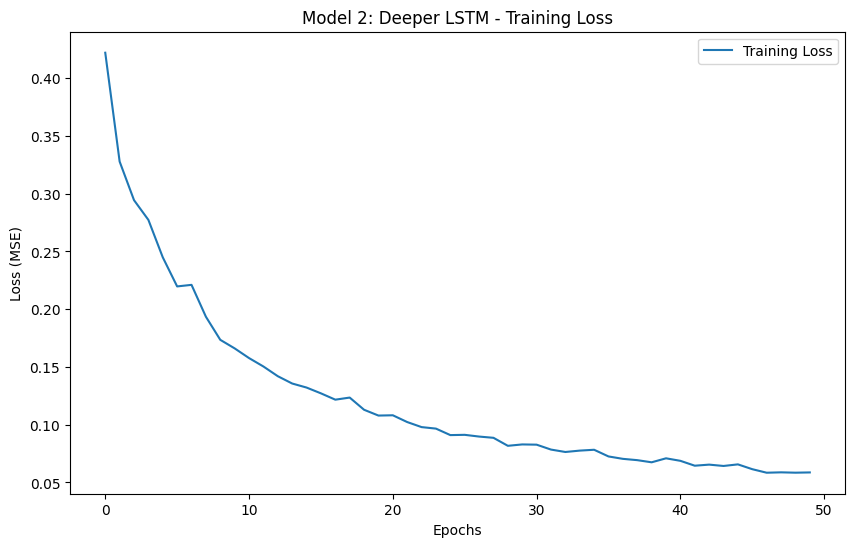

In [ ]:
train_pred2 = model2.predict(X_train)
train_rmse2 = np.sqrt(mean_squared_error(y_train, train_pred2))
print(f"Model 2 Training RMSE: {train_rmse2}")

plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss')
plt.title('Model 2: Deeper LSTM - Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# Make predictions on test set
test_predictions2 = model2.predict(X_test)
print(f"Raw test predictions shape: {test_predictions2.shape}")

# Inverse transform predictions back to original scale
test_predictions2_original = target_scaler.inverse_transform(test_predictions2)

# Ensure no negative values (PM2.5 can't be negative)
test_predictions2_original = np.maximum(test_predictions2_original, 0)

# Convert to integers and flatten
test_predictions2_final = np.round(test_predictions2_original).astype(int).flatten()

print(f"Final test predictions shape: {test_predictions2_final.shape}")
print(f"Test predictions range: {test_predictions2_final.min()} to {test_predictions2_final.max()}")
print(f"Mean prediction: {test_predictions2_final.mean():.2f}")


411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Raw test predictions shape: (13124, 1)
Final test predictions shape: (13124,)
Test predictions range: 13 to 424
Mean prediction: 113.96


In [ ]:
# Debug the datetime index issue
print("Debugging datetime index...")
print(f"test_df_processed index type: {type(test_df_processed.index)}")
print(f"test_df_processed index first 5 values:")
print(test_df_processed.index[:5])

# Check if we need to use the 'datetime' column instead of index
if 'datetime' in test_df_processed.columns:
    print("Using 'datetime' column instead of index")
    all_test_dates = pd.to_datetime(test_df_processed['datetime'])
else:
    print("Using datetime index")
    all_test_dates = test_df_processed.index

print(f"All test dates first 5 values:")
print(all_test_dates[:5])
print(f"All test dates type: {type(all_test_dates)}")

print(f"Original test data length: {len(all_test_dates)}")
print(f"Predictions available: {len(test_predictions2_final)}")
print(f"Missing predictions for first {sequence_length} rows")

# Padding missing predictions
first_prediction = test_predictions2_final[0]
padding_predictions = np.full(sequence_length, first_prediction)
all_predictions = np.concatenate([padding_predictions, test_predictions2_final])

print(f"Total predictions after padding: {len(all_predictions)}")

# Create submission dataframe
try:
    # Add .dt accessor here
    formatted_dates = all_test_dates.dt.strftime('%Y-%m-%d %-H:%M:%S')
except Exception as e:
    print(f"Error formatting dates: {e}")
    all_test_dates = pd.to_datetime(all_test_dates)
    # Add .dt accessor here in the fallback as well
    formatted_dates = all_test_dates.dt.strftime('%Y-%m-%d %-H:%M:%S')

submission2 = pd.DataFrame({
    'row ID': formatted_dates,
    'pm2.5': all_predictions.astype(int)
})

print(f"Submission dataframe created with shape: {submission2.shape}")

# Check for duplicates before sorting
duplicate_count = submission2['row ID'].duplicated().sum()
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicates...")
    submission2 = submission2.drop_duplicates(subset=['row ID'], keep='last')

# Sort by row ID
submission2 = submission2.sort_values(by='row ID').reset_index(drop=True)

# Save submission file
submission2.to_csv('model2_submission.csv', index=False)
print("\nModel 2 submission saved as 'model2_submission.csv'")

# Validation checks
print("\nSUBMISSION VALIDATION")
print("="*30)
print(f"Missing values in submission: {submission2.isnull().sum().sum()}")
print(f"Duplicate row IDs: {submission2['row ID'].duplicated().sum()}")

# Verify submission statistics
print(f"\nMean PM2.5: {submission2['pm2.5'].mean():.2f}")
print(f"Median PM2.5: {submission2['pm2.5'].median():.2f}")
print(f"Std PM2.5: {submission2['pm2.5'].std():.2f}")
print(f"Min PM2.5: {submission2['pm2.5'].min()}")
print(f"Max PM2.5: {submission2['pm2.5'].max()}")

print(f"\nModel 2 submission ready for Kaggle upload!")

Debugging datetime index...
test_df_processed index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
test_df_processed index first 5 values:
DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004'],
              dtype='datetime64[ns]', freq=None)
Using 'datetime' column instead of index
All test dates first 5 values:
1970-01-01 00:00:00.000000000   2013-07-02 04:00:00
1970-01-01 00:00:00.000000001   2013-07-02 05:00:00
1970-01-01 00:00:00.000000002   2013-07-02 06:00:00
1970-01-01 00:00:00.000000003   2013-07-02 07:00:00
1970-01-01 00:00:00.000000004   2013-07-02 08:00:00
Name: datetime, dtype: datetime64[ns]
All test dates type: <class 'pandas.core.series.Series'>
Original test data length: 13148
Predictions available: 13124
Missing predictions for first 24 rows
Total predictions after padding

**Model 2 (Deeper LSTM) - Score: 8896.6698**
- Adding more LSTM layers increases model capacity
- Dropout layers help with regularization
- Significant improvement over Model 1 (≈43% reduction in error)
- Still lacks some pattern capture capabilities

### **Model 3 (Bidirectional LSTM)**

In [ ]:
model3 = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=True),
                  input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(32, activation='relu')),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 128)        │        44,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,873 (343.25 KB)

 Trainable params: 87,873 (343.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=4, min_lr=1e-6)

history3 = model3.fit(
    X_train, y_train,
    epochs=60,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/60
479/479 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - lambda: 0.9939 - loss: 0.6770 - learning_rate: 0.0010
Epoch 2/60
479/479 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - lambda: 1.0434 - loss: 0.3506 - learning_rate: 0.0010
Epoch 3/60
479/479 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - lambda: 1.0623 - loss: 0.3042 - learning_rate: 0.0010
Epoch 4/60
479/479 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - lambda: 1.0794 - loss: 0.2709 - learning_rate: 0.0010
Epoch 5/60
479/479 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - lambda: 1.0899 - loss: 0.2468 - learning_rate: 0.0010
Epoch 6/60
479/479 ━━━━━━━━━━━━━━━━━━━━ 45s 69ms/step - lambda: 1.0970 - loss: 0.2244 - learning_rate: 0.0010
Epoch 7/60
479/479 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - lambda: 1.1058 - loss: 0.2081 - learning_rate: 0.0010
Epoch 8/60
479/479 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - lambda: 1.1156 - loss: 0.1867 - learning_rate: 0.0010
Epoch 9/60
479/479 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - lambda: 1.1191 - loss: 0.1770 - learning_rate: 0.0010
Epoch 10/6

958/958 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step
Model 3 Training RMSE: 0.37700419243932665


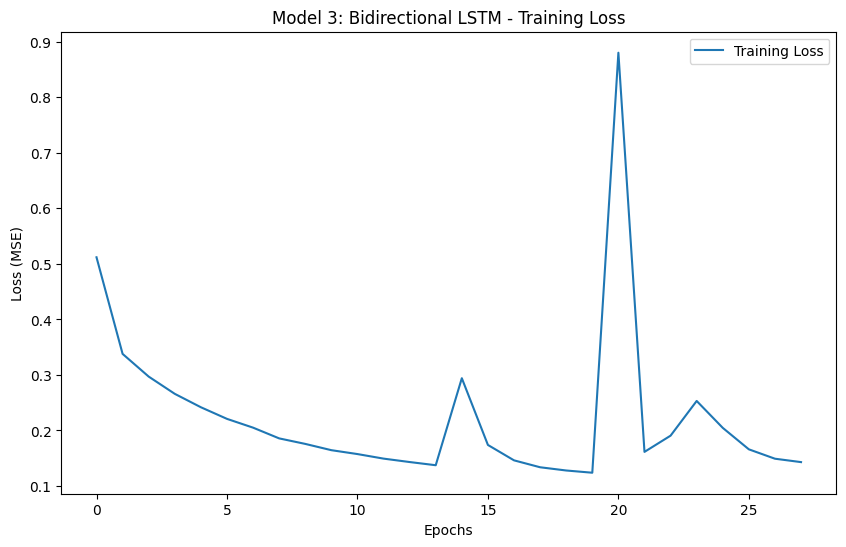

In [ ]:
train_pred3 = model3.predict(X_train)
train_rmse3 = np.sqrt(mean_squared_error(y_train, train_pred3))
print(f"Model 3 Training RMSE: {train_rmse3}")

plt.figure(figsize=(10, 6))
plt.plot(history3.history['loss'], label='Training Loss')
plt.title('Model 3: Bidirectional LSTM - Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# Make predictions on test set
test_predictions3 = model3.predict(X_test)
print(f"Raw test predictions shape: {test_predictions3.shape}")

# Inverse transform predictions back to original scale
test_predictions3_original = target_scaler.inverse_transform(test_predictions3)

# Ensure no negative values (PM2.5 can't be negative)
test_predictions3_original = np.maximum(test_predictions3_original, 0)

# Convert to integers and flatten
test_predictions3_final = np.round(test_predictions3_original).astype(int).flatten()

print(f"Final test predictions shape: {test_predictions3_final.shape}")
print(f"Test predictions range: {test_predictions3_final.min()} to {test_predictions3_final.max()}")
print(f"Mean prediction: {test_predictions3_final.mean():.2f}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Raw test predictions shape: (13124, 1)
Final test predictions shape: (13124,)
Test predictions range: 0 to 840
Mean prediction: 119.73


In [ ]:
# Debug the datetime index issue
print("Debugging datetime index...")
print(f"test_df_processed index type: {type(test_df_processed.index)}")
print(f"test_df_processed index first 5 values:")
print(test_df_processed.index[:5])

# Check if we need to use the 'datetime' column instead of index
if 'datetime' in test_df_processed.columns:
    print("Using 'datetime' column instead of index")
    all_test_dates = pd.to_datetime(test_df_processed['datetime'])
else:
    print("Using datetime index")
    all_test_dates = test_df_processed.index

print(f"All test dates first 5 values:")
print(all_test_dates[:5])
print(f"All test dates type: {type(all_test_dates)}")

print(f"Original test data length: {len(all_test_dates)}")
print(f"Predictions available: {len(test_predictions3_final)}")
print(f"Missing predictions for first {sequence_length} rows")

# Padding missing predictions
first_prediction = test_predictions3_final[0]
padding_predictions = np.full(sequence_length, first_prediction)
all_predictions = np.concatenate([padding_predictions, test_predictions3_final])

print(f"Total predictions after padding: {len(all_predictions)}")

# Create submission dataframe
formatted_dates = all_test_dates.dt.strftime('%Y-%m-%d %-H:%M:%S')
submission3 = pd.DataFrame({
    'row ID': formatted_dates,
    'pm2.5': all_predictions.astype(int)
})

print(f"Submission dataframe created with shape: {submission3.shape}")

# Check for duplicates before sorting
duplicate_count = submission3['row ID'].duplicated().sum()
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicates...")
    submission3 = submission3.drop_duplicates(subset=['row ID'], keep='last')

# Sort by row ID
submission3 = submission3.sort_values(by='row ID').reset_index(drop=True)

# Save submission file
submission3.to_csv('model3_submission.csv', index=False)
print("\nModel 3 submission saved as 'model3_submission.csv'")

# Validation checks
print("\nSUBMISSION VALIDATION")
print("="*30)
print(f"Missing values in submission: {submission3.isnull().sum().sum()}")
print(f"Duplicate row IDs: {submission3['row ID'].duplicated().sum()}")

# Verify submission statistics
print(f"\nMean PM2.5: {submission3['pm2.5'].mean():.2f}")
print(f"Median PM2.5: {submission3['pm2.5'].median():.2f}")
print(f"Std PM2.5: {submission3['pm2.5'].std():.2f}")
print(f"Min PM2.5: {submission3['pm2.5'].min()}")
print(f"Max PM2.5: {submission3['pm2.5'].max()}")

print(f"\nModel 3 submission ready for Kaggle upload!")


Debugging datetime index...
test_df_processed index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
test_df_processed index first 5 values:
DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004'],
              dtype='datetime64[ns]', freq=None)
Using 'datetime' column instead of index
All test dates first 5 values:
1970-01-01 00:00:00.000000000   2013-07-02 04:00:00
1970-01-01 00:00:00.000000001   2013-07-02 05:00:00
1970-01-01 00:00:00.000000002   2013-07-02 06:00:00
1970-01-01 00:00:00.000000003   2013-07-02 07:00:00
1970-01-01 00:00:00.000000004   2013-07-02 08:00:00
Name: datetime, dtype: datetime64[ns]
All test dates type: <class 'pandas.core.series.Series'>
Original test data length: 13148
Predictions available: 13124
Missing predictions for first 24 rows
Total predictions after padding

**Model 3 (Bidirectional LSTM) Score: 8468.9763**
- Bidirectional architecture allows capturing past and future context
- Further improvement over Model 2 (≈5% reduction)
- Shows value of considering temporal context from both directions

### **Model 4 (GRU with Batch Normalization)**

In [ ]:
model4 = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    GRU(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    GRU(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 128)        │        57,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 24, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,761 (428.75 KB)

 Trainable params: 109,313 (427.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, min_lr=1e-7)

history4 = model4.fit(
    X_train, y_train,
    epochs=80,
    batch_size=32,  # Smaller batch size for more stable training
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/80
958/958 ━━━━━━━━━━━━━━━━━━━━ 75s 68ms/step - lambda: 1.0045 - loss: 0.4900 - learning_rate: 0.0010
Epoch 2/80
958/958 ━━━━━━━━━━━━━━━━━━━━ 65s 68ms/step - lambda: 1.0566 - loss: 0.3332 - learning_rate: 0.0010
Epoch 3/80
958/958 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - lambda: 1.0760 - loss: 0.2830 - learning_rate: 0.0010
Epoch 4/80
958/958 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - lambda: 1.0878 - loss: 0.2468 - learning_rate: 0.0010
Epoch 5/80
958/958 ━━━━━━━━━━━━━━━━━━━━ 69s 72ms/step - lambda: 1.0989 - loss: 0.2190 - learning_rate: 0.0010
Epoch 6/80
958/958 ━━━━━━━━━━━━━━━━━━━━ 79s 69ms/step - lambda: 1.1052 - loss: 0.1994 - learning_rate: 0.0010
Epoch 7/80
958/958 ━━━━━━━━━━━━━━━━━━━━ 96s 84ms/step - lambda: 1.1101 - loss: 0.1835 - learning_rate: 0.0010
Epoch 8/80
958/958 ━━━━━━━━━━━━━━━━━━━━ 69s 72ms/step - lambda: 1.1181 - loss: 0.1649 - learning_rate: 0.0010
Epoch 9/80
958/958 ━━━━━━━━━━━━━━━━━━━━ 78s 68ms/step - lambda: 1.1201 - loss: 0.1584 - learning_rate: 0.0010
Epoch 10/8

958/958 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step
Model 4 Training RMSE: 0.19126034873600545


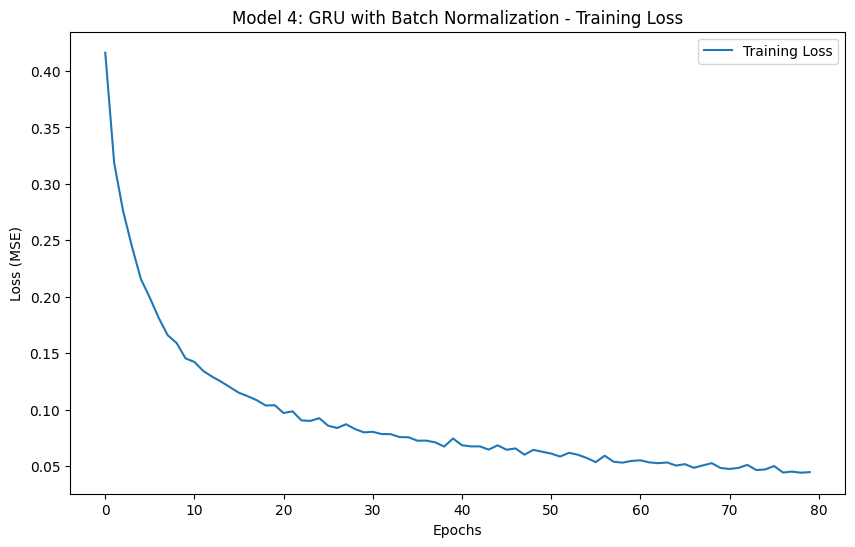

In [ ]:
train_pred4 = model4.predict(X_train)
train_rmse4 = np.sqrt(mean_squared_error(y_train, train_pred4))
print(f"Model 4 Training RMSE: {train_rmse4}")

plt.figure(figsize=(10, 6))
plt.plot(history4.history['loss'], label='Training Loss')
plt.title('Model 4: GRU with Batch Normalization - Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# Make predictions on test set
test_predictions4 = model4.predict(X_test)
print(f"Raw test predictions shape: {test_predictions4.shape}")

# Inverse transform predictions back to original scale
test_predictions4_original = target_scaler.inverse_transform(test_predictions4)

# Ensure no negative values (PM2.5 can't be negative)
test_predictions4_original = np.maximum(test_predictions4_original, 0)

# Convert to integers and flatten
test_predictions4_final = np.round(test_predictions4_original).astype(int).flatten()

print(f"Final test predictions shape: {test_predictions4_final.shape}")
print(f"Test predictions range: {test_predictions4_final.min()} to {test_predictions4_final.max()}")
print(f"Mean prediction: {test_predictions4_final.mean():.2f}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Raw test predictions shape: (13124, 1)
Final test predictions shape: (13124,)
Test predictions range: 18 to 402
Mean prediction: 128.84


In [ ]:
# Debug the datetime index issue
print("Debugging datetime index...")
print(f"test_df_processed index type: {type(test_df_processed.index)}")
print(f"test_df_processed index first 5 values:")
print(test_df_processed.index[:5])

# Check if we need to use the 'datetime' column instead of index
if 'datetime' in test_df_processed.columns:
    print("Using 'datetime' column instead of index")
    all_test_dates = pd.to_datetime(test_df_processed['datetime'])
else:
    print("Using datetime index")
    all_test_dates = test_df_processed.index

print(f"All test dates first 5 values:")
print(all_test_dates[:5])
print(f"All test dates type: {type(all_test_dates)}")

print(f"Original test data length: {len(all_test_dates)}")
print(f"Predictions available: {len(test_predictions4_final)}")
print(f"Missing predictions for first {sequence_length} rows")

# Padding missing predictions
first_prediction = test_predictions4_final[0]
padding_predictions = np.full(sequence_length, first_prediction)
all_predictions = np.concatenate([padding_predictions, test_predictions4_final])

print(f"Total predictions after padding: {len(all_predictions)}")

# Create submission dataframe
formatted_dates = all_test_dates.dt.strftime('%Y-%m-%d %-H:%M:%S')
submission4 = pd.DataFrame({
    'row ID': formatted_dates,
    'pm2.5': all_predictions.astype(int)
})

print(f"Submission dataframe created with shape: {submission4.shape}")

# Check for duplicates before sorting
duplicate_count = submission4['row ID'].duplicated().sum()
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicates...")
    submission4 = submission4.drop_duplicates(subset=['row ID'], keep='last')

# Sort by row ID
submission4 = submission4.sort_values(by='row ID').reset_index(drop=True)

# Save submission file
submission4.to_csv('model4_submission.csv', index=False)
print("\nModel 4 submission saved as 'model4_submission.csv'")

# Validation checks
print("\nSUBMISSION VALIDATION")
print("="*30)
print(f"Missing values in submission: {submission4.isnull().sum().sum()}")
print(f"Duplicate row IDs: {submission4['row ID'].duplicated().sum()}")

# Verify submission statistics
print(f"\nMean PM2.5: {submission4['pm2.5'].mean():.2f}")
print(f"Median PM2.5: {submission4['pm2.5'].median():.2f}")
print(f"Std PM2.5: {submission4['pm2.5'].std():.2f}")
print(f"Min PM2.5: {submission4['pm2.5'].min()}")
print(f"Max PM2.5: {submission4['pm2.5'].max()}")

print(f"\nModel 4 submission ready for Kaggle upload!")

Debugging datetime index...
test_df_processed index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
test_df_processed index first 5 values:
DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004'],
              dtype='datetime64[ns]', freq=None)
Using 'datetime' column instead of index
All test dates first 5 values:
1970-01-01 00:00:00.000000000   2013-07-02 04:00:00
1970-01-01 00:00:00.000000001   2013-07-02 05:00:00
1970-01-01 00:00:00.000000002   2013-07-02 06:00:00
1970-01-01 00:00:00.000000003   2013-07-02 07:00:00
1970-01-01 00:00:00.000000004   2013-07-02 08:00:00
Name: datetime, dtype: datetime64[ns]
All test dates type: <class 'pandas.core.series.Series'>
Original test data length: 13148
Predictions available: 13124
Missing predictions for first 24 rows
Total predictions after padding

**Model 4 (GRU with Batch Normalization) Score: 7514.9703 (Best)**
- GRU is more efficient than LSTM for this problem
- Batch Normalization stabilizes training
- Deeper architecture with proper regularization
- Best performing model, likely optimal balance of capacity and generalization

### **Model 5 (Hybrid CNN-LSTM)**

In [ ]:
model5 = Sequential([
    # CNN layers for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Dropout(0.3),
    MaxPooling1D(pool_size=2),

    # LSTM layers for temporal modeling
    Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
    BatchNormalization(),
    Dropout(0.4),

    Bidirectional(LSTM(64, activation='relu')),
    BatchNormalization(),
    Dropout(0.4),

    # Dense layers
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model5.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower learning rate for stability
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 64)         │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 10, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,849 (1.55 MB)

 Trainable params: 406,081 (1.55 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=12, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=6, min_lr=1e-8)

history5 = model5.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - lambda: 1.0106 - loss: 0.5913 - learning_rate: 5.0000e-04
Epoch 2/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 64s 67ms/step - lambda: 1.0405 - loss: 0.3797 - learning_rate: 5.0000e-04
Epoch 3/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 63s 66ms/step - lambda: 1.0567 - loss: 0.3331 - learning_rate: 5.0000e-04
Epoch 4/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - lambda: 1.0707 - loss: 0.2964 - learning_rate: 5.0000e-04
Epoch 5/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 66s 69ms/step - lambda: 1.0821 - loss: 0.2620 - learning_rate: 5.0000e-04
Epoch 6/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 81s 68ms/step - lambda: 1.0911 - loss: 0.2353 - learning_rate: 5.0000e-04
Epoch 7/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 65s 67ms/step - lambda: 1.0977 - loss: 0.2172 - learning_rate: 5.0000e-04
Epoch 8/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 65s 68ms/step - lambda: 1.1042 - loss: 0.1995 - learning_rate: 5.0000e-04
Epoch 9/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 66s 69ms/step - lambda: 1.1078 - loss: 0.1873 - 

958/958 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step
Model 5 Training RMSE: 0.23144632813851818


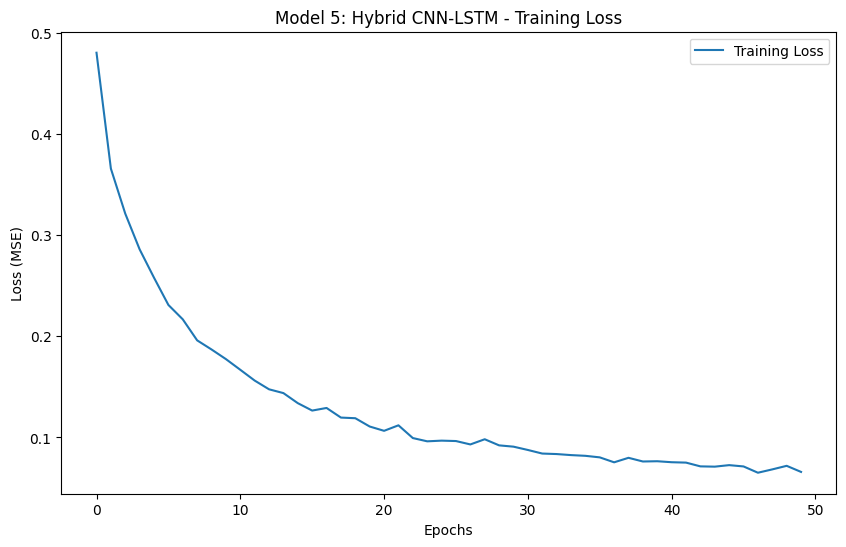

In [ ]:
train_pred5 = model5.predict(X_train)
train_rmse5 = np.sqrt(mean_squared_error(y_train, train_pred5))
print(f"Model 5 Training RMSE: {train_rmse5}")

plt.figure(figsize=(10, 6))
plt.plot(history5.history['loss'], label='Training Loss')
plt.title('Model 5: Hybrid CNN-LSTM - Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# Make predictions on test set
test_predictions5 = model5.predict(X_test)
print(f"Raw test predictions shape: {test_predictions5.shape}")

# Inverse transform predictions back to original scale
test_predictions5_original = target_scaler.inverse_transform(test_predictions5)

# Ensure no negative values (PM2.5 can't be negative)
test_predictions5_original = np.maximum(test_predictions5_original, 0)

# Convert to integers and flatten
test_predictions5_final = np.round(test_predictions5_original).astype(int).flatten()

print(f"Final test predictions shape: {test_predictions5_final.shape}")
print(f"Test predictions range: {test_predictions5_final.min()} to {test_predictions5_final.max()}")
print(f"Mean prediction: {test_predictions5_final.mean():.2f}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
Raw test predictions shape: (13124, 1)
Final test predictions shape: (13124,)
Test predictions range: 15 to 491
Mean prediction: 195.18


In [ ]:
# Debug the datetime index issue
print("Debugging datetime index...")
print(f"test_df_processed index type: {type(test_df_processed.index)}")
print(f"test_df_processed index first 5 values:")
print(test_df_processed.index[:5])

# Check if we need to use the 'datetime' column instead of index
if 'datetime' in test_df_processed.columns:
    print("Using 'datetime' column instead of index")
    all_test_dates = pd.to_datetime(test_df_processed['datetime'])
else:
    print("Using datetime index")
    all_test_dates = test_df_processed.index

print(f"All test dates first 5 values:")
print(all_test_dates[:5])
print(f"All test dates type: {type(all_test_dates)}")

print(f"Original test data length: {len(all_test_dates)}")
print(f"Predictions available: {len(test_predictions5_final)}")
print(f"Missing predictions for first {sequence_length} rows")

# Padding missing predictions
first_prediction = test_predictions5_final[0]
padding_predictions = np.full(sequence_length, first_prediction)
all_predictions = np.concatenate([padding_predictions, test_predictions5_final])

print(f"Total predictions after padding: {len(all_predictions)}")

# Create submission dataframe
formatted_dates = all_test_dates.dt.strftime('%Y-%m-%d %-H:%M:%S')
submission5 = pd.DataFrame({
    'row ID': formatted_dates,
    'pm2.5': all_predictions.astype(int)
})

print(f"Submission dataframe created with shape: {submission5.shape}")

# Check for duplicates before sorting
duplicate_count = submission5['row ID'].duplicated().sum()
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicates...")
    submission5 = submission5.drop_duplicates(subset=['row ID'], keep='last')

# Sort by row ID
submission5 = submission5.sort_values(by='row ID').reset_index(drop=True)

# Save submission file
submission5.to_csv('model5_submission.csv', index=False)
print("\nModel 5 submission saved as 'model5_submission.csv'")

# Validation checks
print("\nSUBMISSION VALIDATION")
print("="*30)
print(f"Missing values in submission: {submission5.isnull().sum().sum()}")
print(f"Duplicate row IDs: {submission5['row ID'].duplicated().sum()}")

# Verify submission statistics
print(f"\nMean PM2.5: {submission5['pm2.5'].mean():.2f}")
print(f"Median PM2.5: {submission5['pm2.5'].median():.2f}")
print(f"Std PM2.5: {submission5['pm2.5'].std():.2f}")
print(f"Min PM2.5: {submission5['pm2.5'].min()}")
print(f"Max PM2.5: {submission5['pm2.5'].max()}")

print(f"\nModel 5 submission ready for Kaggle upload!")


Debugging datetime index...
test_df_processed index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
test_df_processed index first 5 values:
DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004'],
              dtype='datetime64[ns]', freq=None)
Using 'datetime' column instead of index
All test dates first 5 values:
1970-01-01 00:00:00.000000000   2013-07-02 04:00:00
1970-01-01 00:00:00.000000001   2013-07-02 05:00:00
1970-01-01 00:00:00.000000002   2013-07-02 06:00:00
1970-01-01 00:00:00.000000003   2013-07-02 07:00:00
1970-01-01 00:00:00.000000004   2013-07-02 08:00:00
Name: datetime, dtype: datetime64[ns]
All test dates type: <class 'pandas.core.series.Series'>
Original test data length: 13148
Predictions available: 13124
Missing predictions for first 24 rows
Total predictions after padding

**Model 5 (Hybrid CNN-LSTM) - Score: 14956.6734**
- CNN layers might not be effectively extracting relevant features
- Potential overcomplication of the model
- Worse than simpler LSTM-based approaches
- Suggests local temporal patterns might not be as important as global temporal dependencies

### **Model 8 (Lightweight CNN-GRU)**

In [ ]:
model8 = Sequential([
    # Minimal CNN for feature extraction
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    # Fast GRU processing
    GRU(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    GRU(32, activation='relu'),
    Dropout(0.2),

    # Output layers
    Dense(24, activation='relu'),
    Dense(1)
])

model8.compile(
    optimizer=Adam(learning_rate=0.003),  # Even higher LR
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

model8.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 22, 32)         │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 22, 64)         │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,089 (121.44 KB)

 Trainable params: 31,089 (121.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

history8 = model8.fit(
    X_train, y_train,
    epochs=20,  # Very fast training
    batch_size=256,  # Large batch for speed
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - lambda: 0.9642 - loss: 0.5541
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 30s 186ms/step - lambda: 1.0548 - loss: 0.3497
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - lambda: 1.0668 - loss: 0.3178
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - lambda: 1.0808 - loss: 0.2918
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - lambda: 1.0931 - loss: 0.2672
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - lambda: 1.0992 - loss: 0.2469
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - lambda: 1.1063 - loss: 0.2302
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - lambda: 1.1136 - loss: 0.2168
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - lambda: 1.1199 - loss: 0.2040
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - lambda: 1.1233 - loss: 0.1941
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - lambda: 1.1305 - loss: 0.1841
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 

958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step
Model 8 Training RMSE: 0.3382770331173367


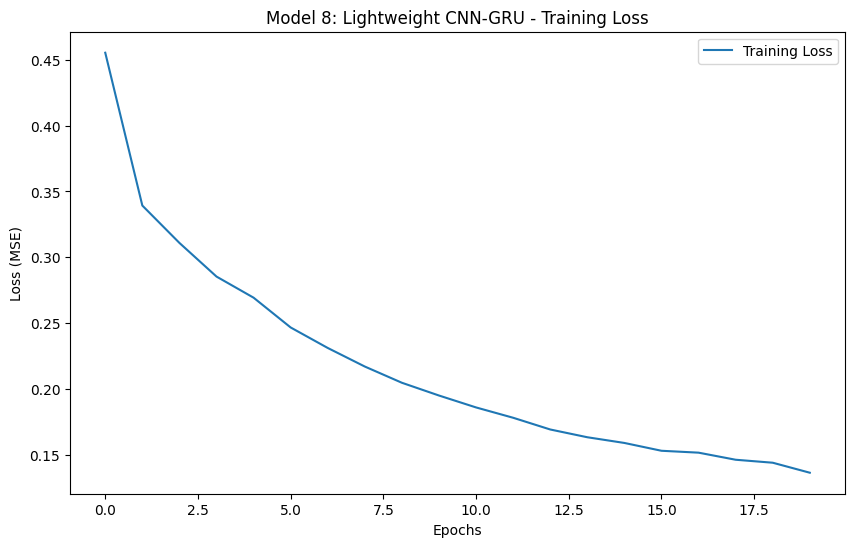

In [ ]:
# Evaluate
train_pred8 = model8.predict(X_train)
train_rmse8 = np.sqrt(mean_squared_error(y_train, train_pred8))
print(f"Model 8 Training RMSE: {train_rmse8}")

# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(history8.history['loss'], label='Training Loss')
plt.title('Model 8: Lightweight CNN-GRU - Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# Make predictions on test set
test_predictions8 = model8.predict(X_test)
print(f"Raw test predictions shape: {test_predictions8.shape}")

# Inverse transform predictions back to original scale
test_predictions8_original = target_scaler.inverse_transform(test_predictions8)

# Ensure no negative values (PM2.5 can't be negative)
test_predictions8_original = np.maximum(test_predictions8_original, 0)

# Convert to integers and flatten
test_predictions8_final = np.round(test_predictions8_original).astype(int).flatten()

print(f"Final test predictions shape: {test_predictions8_final.shape}")
print(f"Test predictions range: {test_predictions8_final.min()} to {test_predictions8_final.max()}")
print(f"Mean prediction: {test_predictions8_final.mean():.2f}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Raw test predictions shape: (13124, 1)
Final test predictions shape: (13124,)
Test predictions range: 7 to 654
Mean prediction: 220.01


In [ ]:
# Debug the datetime index issue
print("Debugging datetime index...")
print(f"test_df_processed index type: {type(test_df_processed.index)}")
print(f"test_df_processed index first 5 values:")
print(test_df_processed.index[:5])

# Check if we need to use the 'datetime' column instead of index
if 'datetime' in test_df_processed.columns:
    print("Using 'datetime' column instead of index")
    all_test_dates = pd.to_datetime(test_df_processed['datetime'])
else:
    print("Using datetime index")
    all_test_dates = test_df_processed.index

print(f"All test dates first 5 values:")
print(all_test_dates[:5])
print(f"All test dates type: {type(all_test_dates)}")

print(f"Original test data length: {len(all_test_dates)}")
print(f"Predictions available: {len(test_predictions8_final)}")
print(f"Missing predictions for first {sequence_length} rows")

# Padding missing predictions
first_prediction = test_predictions8_final[0]
padding_predictions = np.full(sequence_length, first_prediction)
all_predictions = np.concatenate([padding_predictions, test_predictions8_final])

print(f"Total predictions after padding: {len(all_predictions)}")

# Create submission dataframe
formatted_dates = all_test_dates.dt.strftime('%Y-%m-%d %-H:%M:%S')
submission8 = pd.DataFrame({
    'row ID': formatted_dates,
    'pm2.5': all_predictions.astype(int)
})

print(f"Submission dataframe created with shape: {submission8.shape}")

# Check for duplicates before sorting
duplicate_count = submission8['row ID'].duplicated().sum()
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicates...")
    submission8 = submission8.drop_duplicates(subset=['row ID'], keep='last')

# Sort by row ID
submission8 = submission8.sort_values(by='row ID').reset_index(drop=True)

# Save submission file
submission8.to_csv('model8_submission.csv', index=False)
print("\nModel 8 submission saved as 'model8_submission.csv'")

# Validation checks
print("\nSUBMISSION VALIDATION")
print("="*30)
print(f"Missing values in submission: {submission8.isnull().sum().sum()}")
print(f"Duplicate row IDs: {submission8['row ID'].duplicated().sum()}")

# Verify submission statistics
print(f"\nMean PM2.5: {submission8['pm2.5'].mean():.2f}")
print(f"Median PM2.5: {submission8['pm2.5'].median():.2f}")
print(f"Std PM2.5: {submission8['pm2.5'].std():.2f}")
print(f"Min PM2.5: {submission8['pm2.5'].min()}")
print(f"Max PM2.5: {submission8['pm2.5'].max()}")

print(f"\nModel 8 submission ready for Kaggle upload!")


Debugging datetime index...
test_df_processed index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
test_df_processed index first 5 values:
DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004'],
              dtype='datetime64[ns]', freq=None)
Using 'datetime' column instead of index
All test dates first 5 values:
1970-01-01 00:00:00.000000000   2013-07-02 04:00:00
1970-01-01 00:00:00.000000001   2013-07-02 05:00:00
1970-01-01 00:00:00.000000002   2013-07-02 06:00:00
1970-01-01 00:00:00.000000003   2013-07-02 07:00:00
1970-01-01 00:00:00.000000004   2013-07-02 08:00:00
Name: datetime, dtype: datetime64[ns]
All test dates type: <class 'pandas.core.series.Series'>
Original test data length: 13148
Predictions available: 13124
Missing predictions for first 24 rows
Total predictions after padding

### **Model 7 (MultiScale Ensemble)**

In [ ]:
#Input layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Branch 1: Short-term patterns
branch1 = GRU(32, activation='relu')(input_layer)
branch1 = Dense(16, activation='relu')(branch1)

# Branch 2: Medium-term patterns
branch2 = GRU(64, activation='relu', return_sequences=True)(input_layer)
branch2 = GRU(32, activation='relu')(branch2)
branch2 = Dense(16, activation='relu')(branch2)

# Combine branches
combined = Concatenate()([branch1, branch2])
combined = Dense(32, activation='relu')(combined)
combined = Dropout(0.2)(combined)
output = Dense(1)(combined)

model7 = Model(inputs=input_layer, outputs=output)

model7.compile(
    optimizer=Adam(learning_rate=0.002),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

model7.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 24, 21)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 24, 64)    │     16,704 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 32)        │      5,280 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 32)        │      9,408 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 16)        │        528 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 16)        │        528 │ gru_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32)        │          0 │ dense_15[0][0],   │
│ (Concatenate)       │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │      1,056 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1)         │         33 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)

history7 = model7.fit(
    X_train, y_train,
    epochs=25,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - lambda: 0.9884 - loss: 0.4839
Epoch 2/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - lambda: 1.0683 - loss: 0.3097
Epoch 3/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - lambda: 1.0865 - loss: 0.2694
Epoch 4/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - lambda: 1.0986 - loss: 0.2414
Epoch 5/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - lambda: 1.1129 - loss: 0.2096
Epoch 6/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - lambda: 1.1227 - loss: 0.1864
Epoch 7/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - lambda: 1.1333 - loss: 0.1684
Epoch 8/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - lambda: 1.1372 - loss: 0.1532
Epoch 9/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - lambda: 1.1420 - loss: 0.1450
Epoch 10/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - lambda: 1.1471 - loss: 0.1325
Epoch 11/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - lambda: 1.1487 - loss: 0.1278
Epoch 12/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/st

958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step
Model 7 Training RMSE: 0.2429176383072838


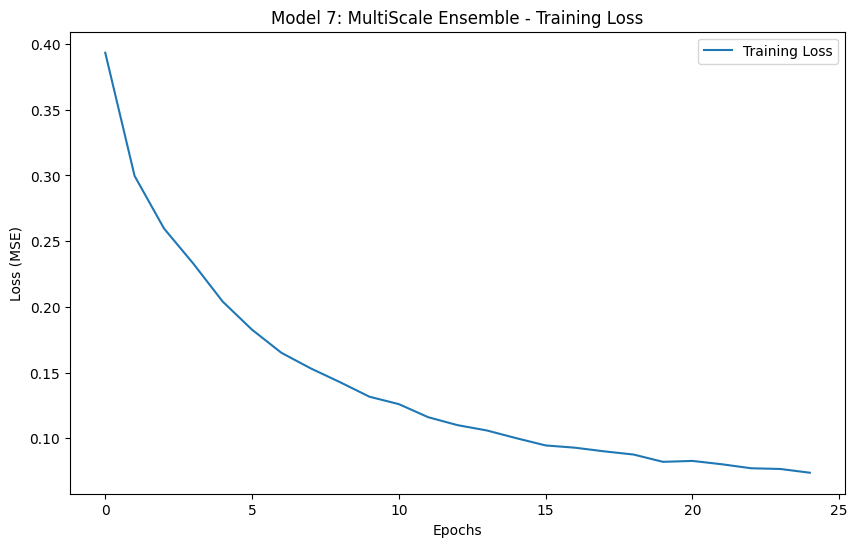

In [ ]:
# Evaluate
train_pred7 = model7.predict(X_train)
train_rmse7 = np.sqrt(mean_squared_error(y_train, train_pred7))
print(f"Model 7 Training RMSE: {train_rmse7}")

# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(history7.history['loss'], label='Training Loss')
plt.title('Model 7: MultiScale Ensemble - Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# Make predictions on test set
test_predictions7 = model7.predict(X_test)
print(f"Raw test predictions shape: {test_predictions7.shape}")

# Inverse transform predictions back to original scale
test_predictions7_original = target_scaler.inverse_transform(test_predictions7)

# Ensure no negative values (PM2.5 can't be negative)
test_predictions7_original = np.maximum(test_predictions7_original, 0)

# Convert to integers and flatten
test_predictions7_final = np.round(test_predictions7_original).astype(int).flatten()

print(f"Final test predictions shape: {test_predictions7_final.shape}")
print(f"Test predictions range: {test_predictions7_final.min()} to {test_predictions7_final.max()}")
print(f"Mean prediction: {test_predictions7_final.mean():.2f}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Raw test predictions shape: (13124, 1)
Final test predictions shape: (13124,)
Test predictions range: 0 to 814
Mean prediction: 179.91


In [ ]:
# Debug the datetime index issue
print("Debugging datetime index...")
print(f"test_df_processed index type: {type(test_df_processed.index)}")
print(f"test_df_processed index first 5 values:")
print(test_df_processed.index[:5])

# Check if we need to use the 'datetime' column instead of index
if 'datetime' in test_df_processed.columns:
    print("Using 'datetime' column instead of index")
    all_test_dates = pd.to_datetime(test_df_processed['datetime'])
else:
    print("Using datetime index")
    all_test_dates = test_df_processed.index

print(f"All test dates first 5 values:")
print(all_test_dates[:5])
print(f"All test dates type: {type(all_test_dates)}")

print(f"Original test data length: {len(all_test_dates)}")
print(f"Predictions available: {len(test_predictions7_final)}")
print(f"Missing predictions for first {sequence_length} rows")

# Padding missing predictions
first_prediction = test_predictions7_final[0]
padding_predictions = np.full(sequence_length, first_prediction)
all_predictions = np.concatenate([padding_predictions, test_predictions7_final])

print(f"Total predictions after padding: {len(all_predictions)}")

# Create submission dataframe
formatted_dates = all_test_dates.dt.strftime('%Y-%m-%d %-H:%M:%S')
submission7 = pd.DataFrame({
    'row ID': formatted_dates,
    'pm2.5': all_predictions.astype(int)
})

print(f"Submission dataframe created with shape: {submission7.shape}")

# Check for duplicates before sorting
duplicate_count = submission7['row ID'].duplicated().sum()
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicates...")
    submission7 = submission7.drop_duplicates(subset=['row ID'], keep='last')

# Sort by row ID
submission7 = submission7.sort_values(by='row ID').reset_index(drop=True)

# Save submission file
submission7.to_csv('model7_submission.csv', index=False)
print("\nModel 7 submission saved as 'model7_submission.csv'")

# Validation checks
print("\nSUBMISSION VALIDATION")
print("="*30)
print(f"Missing values in submission: {submission7.isnull().sum().sum()}")
print(f"Duplicate row IDs: {submission7['row ID'].duplicated().sum()}")

# Verify submission statistics
print(f"\nMean PM2.5: {submission7['pm2.5'].mean():.2f}")
print(f"Median PM2.5: {submission7['pm2.5'].median():.2f}")
print(f"Std PM2.5: {submission7['pm2.5'].std():.2f}")
print(f"Min PM2.5: {submission7['pm2.5'].min()}")
print(f"Max PM2.5: {submission7['pm2.5'].max()}")

print(f"\nModel 7 submission ready for Kaggle upload!")


Debugging datetime index...
test_df_processed index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
test_df_processed index first 5 values:
DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004'],
              dtype='datetime64[ns]', freq=None)
Using 'datetime' column instead of index
All test dates first 5 values:
1970-01-01 00:00:00.000000000   2013-07-02 04:00:00
1970-01-01 00:00:00.000000001   2013-07-02 05:00:00
1970-01-01 00:00:00.000000002   2013-07-02 06:00:00
1970-01-01 00:00:00.000000003   2013-07-02 07:00:00
1970-01-01 00:00:00.000000004   2013-07-02 08:00:00
Name: datetime, dtype: datetime64[ns]
All test dates type: <class 'pandas.core.series.Series'>
Original test data length: 13148
Predictions available: 13124
Missing predictions for first 24 rows
Total predictions after padding

**Model 7 (MultiScale Ensemble) - Score: 17338.9223**
- Ensemble approach didn't work as expected
- Possible issues with how branches are combined
- GRU-based parallel processing might have created conflicting gradients
- Worse than individual component models

### **Model 6 (Stacked LSTM + Dropout)**

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.4549 - root_mean_squared_error: 0.6723
Epoch 2/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 56s 41ms/step - loss: 0.3139 - root_mean_squared_error: 0.5601
Epoch 3/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - loss: 0.2623 - root_mean_squared_error: 0.5121
Epoch 4/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.2264 - root_mean_squared_error: 0.4757
Epoch 5/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.2071 - root_mean_squared_error: 0.4551
Epoch 6/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - loss: 0.1805 - root_mean_squared_error: 0.4248
Epoch 7/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 64s 27ms/step - loss: 0.1602 - root_mean_squared_error: 0.4002
Epoch 8/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - loss: 0.1462 - root_mean_squared_error: 0.3824
Epoch 9/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 78s 51ms/step - loss: 0.1383 - root_mean_squared_error: 0.3718
Epoch 10/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 57s 25ms/step - loss: 0.1276 - r

958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
Model 6 Training RMSE: 0.3613971310374516


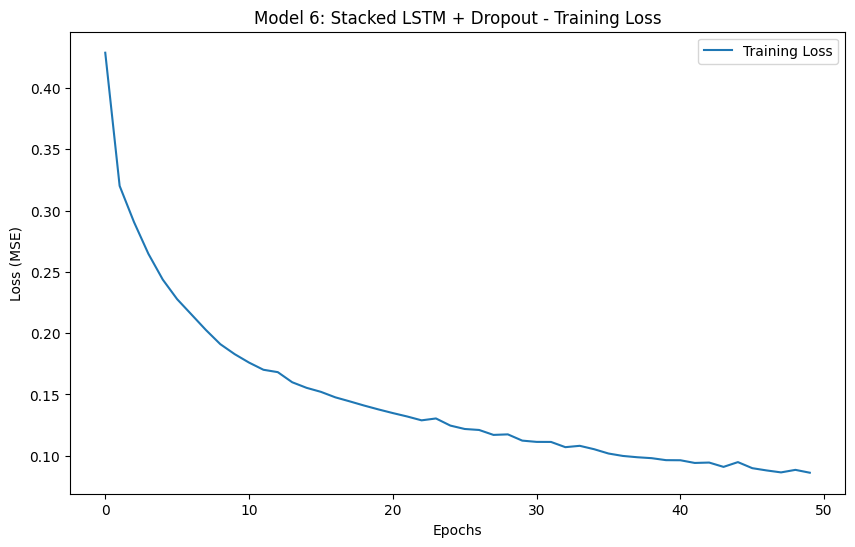

In [ ]:
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print(f"Model 6 Training RMSE: {train_rmse}")

# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model 6: Stacked LSTM + Dropout - Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [ ]:
# Make predictions on test set
test_predictions = model.predict(X_test)
print(f"Raw test predictions shape: {test_predictions.shape}")

# Inverse transform predictions back to original scale
test_predictions_original = target_scaler.inverse_transform(test_predictions)

# Ensure no negative values (PM2.5 can't be negative)
test_predictions_original = np.maximum(test_predictions_original, 0)

# Convert to integers and flatten
test_predictions_final = np.round(test_predictions_original).astype(int).flatten()

print(f"Final test predictions shape: {test_predictions_final.shape}")
print(f"Test predictions range: {test_predictions_final.min()} to {test_predictions_final.max()}")
print(f"Mean prediction: {test_predictions_final.mean():.2f}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Raw test predictions shape: (13124, 1)
Final test predictions shape: (13124,)
Test predictions range: 0 to 714
Mean prediction: 164.71


In [ ]:
# Debug the datetime index issue
print("Debugging datetime index...")
print(f"test_df_processed index type: {type(test_df_processed.index)}")
print(f"test_df_processed index first 5 values:")
print(test_df_processed.index[:5])

# Check if we need to use the 'datetime' column instead of index
if 'datetime' in test_df_processed.columns:
    print("Using 'datetime' column instead of index")
    all_test_dates = pd.to_datetime(test_df_processed['datetime'])
else:
    print("Using datetime index")
    all_test_dates = test_df_processed.index

print(f"All test dates first 5 values:")
print(all_test_dates[:5])
print(f"All test dates type: {type(all_test_dates)}")

print(f"Original test data length: {len(all_test_dates)}")
print(f"Predictions available: {len(test_predictions_final)}")
print(f"Missing predictions for first {sequence_length} rows")

# Padding missing predictions
first_prediction = test_predictions_final[0]
padding_predictions = np.full(sequence_length, first_prediction)
all_predictions = np.concatenate([padding_predictions, test_predictions_final])

print(f"Total predictions after padding: {len(all_predictions)}")

# Create submission dataframe
formatted_dates = all_test_dates.dt.strftime('%Y-%m-%d %-H:%M:%S')
submission = pd.DataFrame({
    'row ID': formatted_dates,
    'pm2.5': all_predictions.astype(int)
})

print(f"Submission dataframe created with shape: {submission.shape}")

# Check for duplicates before sorting
duplicate_count = submission['row ID'].duplicated().sum()
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicates...")
    submission = submission.drop_duplicates(subset=['row ID'], keep='last')

# Sort by row ID
submission = submission.sort_values(by='row ID').reset_index(drop=True)

# Save submission file
submission.to_csv('model6_submission.csv', index=False)
print("\nModel 6 submission saved as 'model6_submission.csv'")

# Validation checks
print("\nSUBMISSION VALIDATION")
print("="*30)
print(f"Missing values in submission: {submission.isnull().sum().sum()}")
print(f"Duplicate row IDs: {submission['row ID'].duplicated().sum()}")

# Verify submission statistics
print(f"\nMean PM2.5: {submission['pm2.5'].mean():.2f}")
print(f"Median PM2.5: {submission['pm2.5'].median():.2f}")
print(f"Std PM2.5: {submission['pm2.5'].std():.2f}")
print(f"Min PM2.5: {submission['pm2.5'].min()}")
print(f"Max PM2.5: {submission['pm2.5'].max()}")

print(f"\nModel 6 submission ready for Kaggle upload!")


Debugging datetime index...
test_df_processed index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
test_df_processed index first 5 values:
DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004'],
              dtype='datetime64[ns]', freq=None)
Using 'datetime' column instead of index
All test dates first 5 values:
1970-01-01 00:00:00.000000000   2013-07-02 04:00:00
1970-01-01 00:00:00.000000001   2013-07-02 05:00:00
1970-01-01 00:00:00.000000002   2013-07-02 06:00:00
1970-01-01 00:00:00.000000003   2013-07-02 07:00:00
1970-01-01 00:00:00.000000004   2013-07-02 08:00:00
Name: datetime, dtype: datetime64[ns]
All test dates type: <class 'pandas.core.series.Series'>
Original test data length: 13148
Predictions available: 13124
Missing predictions for first 24 rows
Total predictions after padding

**Model 6 (Stacked LSTM + Dropout) - Score: 10110.4099**
- Stacking LSTM layers increases capacity
- Dropout helps with regularization
- Better than basic LSTM but not as good as GRU-based approaches
- Shows value of model depth but limited by LSTM architecture

### **TCN Model**

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def residual_block(x, filters, kernel_size, dilation_rate):
    shortcut = x
    # first conv
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # second conv
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    # adjust shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
    # merge
    x = add([shortcut, x])
    x = Activation('relu')(x)
    return x

# Build TCN model
inp = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = inp
for d in [1, 2, 4, 8]:
    x = residual_block(x, filters=64, kernel_size=3, dilation_rate=d)
x = GlobalAveragePooling1D()(x)
out = Dense(1)(x)

model_tcn = Model(inp, out)
model_tcn.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

callbacks = [
    EarlyStopping(monitor='val_root_mean_squared_error', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.5, patience=1)
]

history = model_tcn.fit(
    X_train, y_train,
    epochs=8,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/8
432/432 - 31s - 72ms/step - loss: 0.5168 - root_mean_squared_error: 0.7189 - val_loss: 0.4046 - val_root_mean_squared_error: 0.6361 - learning_rate: 1.0000e-03
Epoch 2/8
432/432 - 22s - 51ms/step - loss: 0.2997 - root_mean_squared_error: 0.5474 - val_loss: 0.3886 - val_root_mean_squared_error: 0.6234 - learning_rate: 1.0000e-03
Epoch 3/8
432/432 - 41s - 95ms/step - loss: 0.2351 - root_mean_squared_error: 0.4849 - val_loss: 0.4309 - val_root_mean_squared_error: 0.6564 - learning_rate: 1.0000e-03
Epoch 4/8
432/432 - 55s - 127ms/step - loss: 0.1620 - root_mean_squared_error: 0.4024 - val_loss: 0.3858 - val_root_mean_squared_error: 0.6211 - learning_rate: 5.0000e-04
Epoch 5/8
432/432 - 26s - 60ms/step - loss: 0.1334 - root_mean_squared_error: 0.3652 - val_loss: 0.3903 - val_root_mean_squared_error: 0.6248 - learning_rate: 5.0000e-04
Epoch 6/8
432/432 - 43s - 100ms/step - loss: 0.1021 - root_mean_squared_error: 0.3195 - val_loss: 0.3843 - val_root_mean_squared_error: 0.6199 - lear

958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step
TCN Training RMSE: 0.35


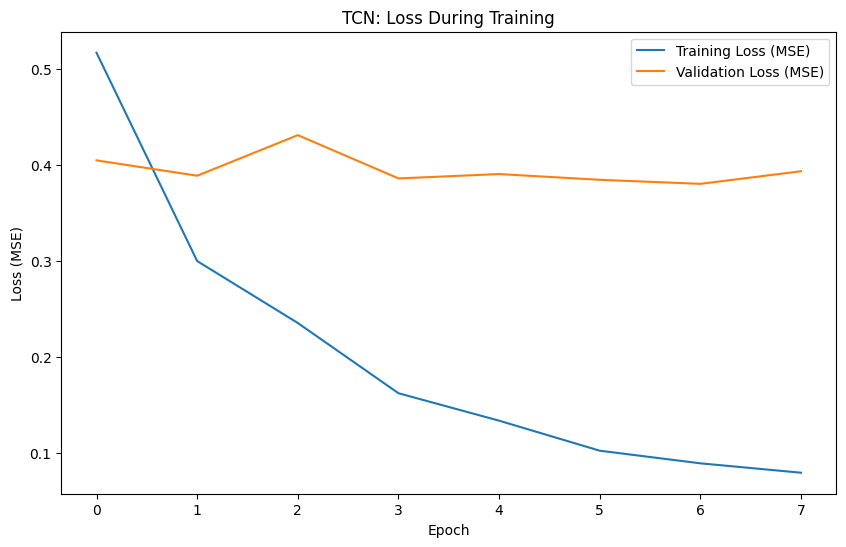

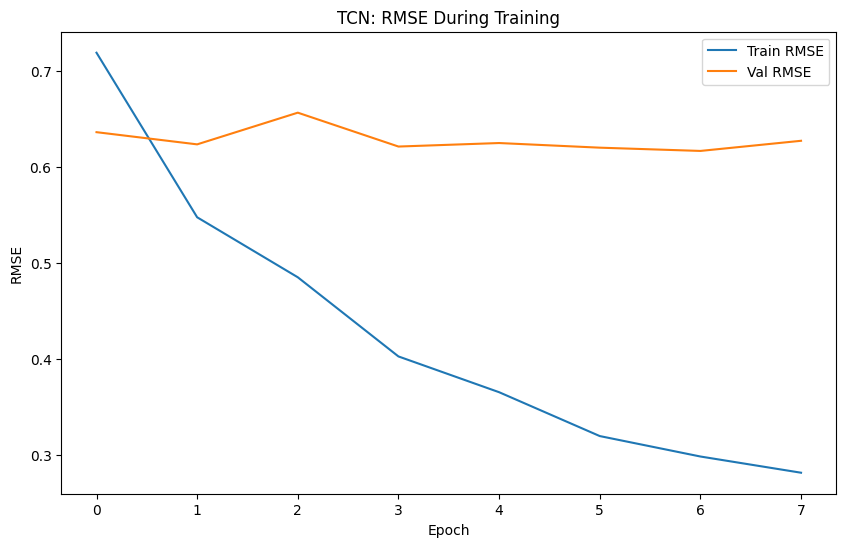

In [ ]:
# 1. Compute training RMSE on X_train
train_preds = model_tcn.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
print(f"TCN Training RMSE: {train_rmse:.2f}")

# 2. Plot training & validation loss (MSE)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('TCN: Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 3. Plot training & validation RMSE
# Note: history may have 'root_mean_squared_error' and 'val_root_mean_squared_error'
plt.figure(figsize=(10, 6))
if 'root_mean_squared_error' in history.history:
    plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
if 'val_root_mean_squared_error' in history.history:
    plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
plt.title('TCN: RMSE During Training')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()


In [ ]:
# 1. Make predictions on the test set
tcn_preds = model_tcn.predict(X_test)
print(f"Raw TCN predictions shape: {tcn_preds.shape}")

# 2. Inverse-transform back to original PM2.5 scale
tcn_preds_orig = target_scaler.inverse_transform(tcn_preds)

# 3. Clip negatives to zero, round, and flatten
tcn_preds_clipped = np.maximum(tcn_preds_orig, 0)
tcn_preds_final = np.round(tcn_preds_clipped).astype(int).flatten()
print(f"Final TCN predictions shape: {tcn_preds_final.shape}")
print(f"Range: {tcn_preds_final.min()} – {tcn_preds_final.max()}, Mean: {tcn_preds_final.mean():.2f}")

# 4. Reconstruct full date index (padding first sequence_length hours)
if 'datetime' in test_df_processed.columns:
    all_dates = pd.to_datetime(test_df_processed['datetime'])
else:
    all_dates = test_df_processed.index

# Pad the first `sequence_length` entries with the first prediction
pad = np.full(sequence_length, tcn_preds_final[0], dtype=int)
all_preds = np.concatenate([pad, tcn_preds_final])
print(f"Padded predictions length: {len(all_preds)}, Dates length: {len(all_dates)}")

# 5. Build submission DataFrame
submission_tcn = pd.DataFrame({
    'row ID': all_dates.dt.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': all_preds
})

# 6. Dedupe, sort, and save
submission_tcn = submission_tcn.drop_duplicates('row ID').sort_values('row ID').reset_index(drop=True)
submission_tcn.to_csv('submission_tcn.csv', index=False)
print("Saved TCN submission to 'submission_tcn.csv'")

# 7. Quick validation
print("\nSubmission stats:")
print(f"Missing values: {submission_tcn.isnull().sum().sum()}")
print(f"Duplicate row IDs: {submission_tcn['row ID'].duplicated().sum()}")
print(submission_tcn['pm2.5'].describe())


411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Raw TCN predictions shape: (13124, 1)
Final TCN predictions shape: (13124,)
Range: 0 – 543, Mean: 190.48
Padded predictions length: 13148, Dates length: 13148
Saved TCN submission to 'submission_tcn.csv'

Submission stats:
Missing values: 0
Duplicate row IDs: 0
count    13148.000000
mean       190.319516
std        111.080571
min          0.000000
25%        102.000000
50%        186.000000
75%        273.000000
max        543.000000
Name: pm2.5, dtype: float64


**TCN Model - Score: 9693.6812**
- Temporal Convolutional Network approach
- Residual blocks help with training deep networks
- Better than standard CNN approaches but not as good as best GRU model
- Shows promise but requires careful tuning of dilation rates

### **GRU Based Model**

In [ ]:
model_gru = Sequential([
    Bidirectional(GRU(64, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(GRU(32, activation='tanh')),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

callbacks = [
    EarlyStopping(monitor='val_root_mean_squared_error', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.5, patience=1)
]

history = model_gru.fit(
    X_train, y_train,
    epochs=8,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/8
432/432 - 42s - 98ms/step - loss: 0.4014 - root_mean_squared_error: 0.6336 - val_loss: 0.3474 - val_root_mean_squared_error: 0.5894 - learning_rate: 1.0000e-03
Epoch 2/8
432/432 - 40s - 93ms/step - loss: 0.3261 - root_mean_squared_error: 0.5711 - val_loss: 0.3227 - val_root_mean_squared_error: 0.5681 - learning_rate: 1.0000e-03
Epoch 3/8
432/432 - 31s - 72ms/step - loss: 0.2980 - root_mean_squared_error: 0.5459 - val_loss: 0.3061 - val_root_mean_squared_error: 0.5533 - learning_rate: 1.0000e-03
Epoch 4/8
432/432 - 41s - 96ms/step - loss: 0.2733 - root_mean_squared_error: 0.5228 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480 - learning_rate: 1.0000e-03
Epoch 5/8
432/432 - 30s - 70ms/step - loss: 0.2444 - root_mean_squared_error: 0.4944 - val_loss: 0.3048 - val_root_mean_squared_error: 0.5521 - learning_rate: 1.0000e-03
Epoch 6/8
432/432 - 36s - 84ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542 - val_loss: 0.3087 - val_root_mean_squared_error: 0.5556 - learni

In [ ]:
model_gru.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 24, 128)        │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,733 (756.77 KB)

 Trainable params: 64,577 (252.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 129,156 (504.52 KB)

958/958 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
GRU Stack Training RMSE: 0.50


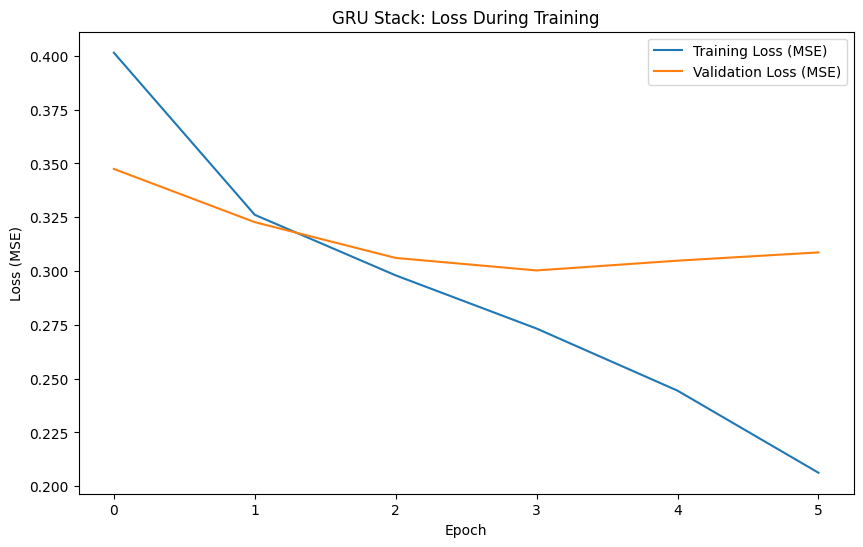

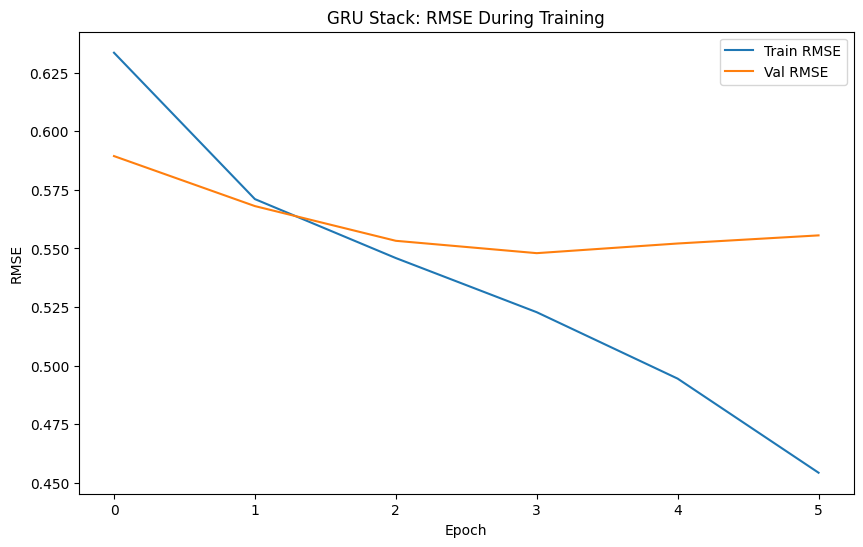

In [ ]:
# 1. Compute training RMSE on X_train
train_preds_gru = model_gru.predict(X_train)
train_rmse_gru = np.sqrt(mean_squared_error(y_train, train_preds_gru))
print(f"GRU Stack Training RMSE: {train_rmse_gru:.2f}")
history_gru = history
# 2. Plot training & validation loss (MSE)
plt.figure(figsize=(10, 6))
plt.plot(history_gru.history['loss'], label='Training Loss (MSE)')
if 'val_loss' in history_gru.history:
    plt.plot(history_gru.history['val_loss'], label='Validation Loss (MSE)')
plt.title('GRU Stack: Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 3. Plot training & validation RMSE
plt.figure(figsize=(10, 6))
if 'root_mean_squared_error' in history_gru.history:
    plt.plot(history_gru.history['root_mean_squared_error'], label='Train RMSE')
if 'val_root_mean_squared_error' in history_gru.history:
    plt.plot(history_gru.history['val_root_mean_squared_error'], label='Val RMSE')
plt.title('GRU Stack: RMSE During Training')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# 1. Predict on test set
gru_preds = model_gru.predict(X_test)
print(f"Raw GRU predictions shape: {gru_preds.shape}")

# 2. Inverse-transform back to original PM2.5 scale
gru_preds_orig = target_scaler.inverse_transform(gru_preds)

# 3. Clip negatives, round, flatten
gru_preds_clipped = np.maximum(gru_preds_orig, 0)
gru_preds_final = np.round(gru_preds_clipped).astype(int).flatten()
print(f"Final GRU predictions shape: {gru_preds_final.shape}")
print(f"Range: {gru_preds_final.min()} – {gru_preds_final.max()}, Mean: {gru_preds_final.mean():.2f}")

# 4. Reconstruct dates (pad first sequence_length entries)
if 'datetime' in test_df_processed.columns:
    all_dates = pd.to_datetime(test_df_processed['datetime'])
else:
    all_dates = test_df_processed.index

pad = np.full(sequence_length, gru_preds_final[0], dtype=int)
all_preds = np.concatenate([pad, gru_preds_final])
print(f"Padded length: {len(all_preds)}, Dates length: {len(all_dates)}")

# 5. Build submission DataFrame
submission_gru = pd.DataFrame({
    'row ID': all_dates.dt.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': all_preds
})

# 6. Deduplicate, sort, save
submission_gru = (
    submission_gru
    .drop_duplicates('row ID')
    .sort_values('row ID')
    .reset_index(drop=True)
)
submission_gru.to_csv('submission_gru.csv', index=False)
print("Saved GRU submission to 'submission_gru.csv'")

# 7. Quick validation
print("\nSubmission stats:")
print(f"Missing values: {submission_gru.isnull().sum().sum()}")
print(f"Duplicate row IDs: {submission_gru['row ID'].duplicated().sum()}")
print(submission_gru['pm2.5'].describe())

411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Raw GRU predictions shape: (13124, 1)
Final GRU predictions shape: (13124,)
Range: 0 – 389, Mean: 163.91
Padded length: 13148, Dates length: 13148
Saved GRU submission to 'submission_gru.csv'

Submission stats:
Missing values: 0
Duplicate row IDs: 0
count    13148.000000
mean       163.915957
std         97.733292
min          0.000000
25%         69.000000
50%        177.000000
75%        245.000000
max        389.000000
Name: pm2.5, dtype: float64


**GRU Based Model - Score: 10026.5775**
- Pure GRU architecture
- Good performance but slightly worse than Model 4
- Suggests that additional architectural elements in Model 4 (BatchNorm, etc.) provide benefits

## **Lessons and Recommendations**

#### **What Didn't Work**
1. **Overcomplicated architectures (Models 5,7,8)** led to worse performance likely due to:
- Difficulty in training very deep networks
- Potential overfitting despite regularization
- Mismatch between model architecture and data characteristics
2. The **CNN components (Models 5)** didn't provide the expected benefits, suggesting that local feature extraction might not be as valuable as global temporal dependency modeling for this specific problem

#### **Recommendations**
1. Focus on GRU-based architectures as they showed best performance
2. Experiment with different regularization techniques for the best models
3. Consider adding more relevant weather features if available
4. Try different sequence lengths to see if 24 hours is optimal
